## Analyze A/B Test Results

### by Jérôme d'Harveng

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
nb_user=df.user_id.nunique()
print(nb_user)

290584


d. The proportion of users converted.

In [6]:
df.query('converted == 1').user_id.count()/nb_user

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('(group=="treatment"& landing_page == "old_page") |(group=="control"& landing_page == "new_page") ')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.query('(group=="treatment"& landing_page == "new_page") |(group=="control"& landing_page == "old_page") ')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

In [12]:
# total size 
df2.shape[0]

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query('user_id ==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop_duplicates(subset=['user_id'],keep='first')

In [16]:
df2.query('user_id ==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.shape[0]

290584

In [21]:
df2.query('landing_page == "new_page"').user_id.count()/df2.shape[0]

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**At this point, probabilities (0.119 and 0.120) are too close, to tell there's any evidence, in favor or not**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0:   $p_{new}$ =  $p_{old}$**

**H1:   $p_{new}$ $\neq$  $p_{old}$**


**NB:** we'll reject H0 if p-value $\leq$ 0.05 and fail to reject it otherwise


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
# with the assumption 2 => under the null : p_new = p_old
p_new = df2.converted.mean()
print(p_new)

0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
print(p_old)

0.119597087245


c. What is $n_{new}$?

In [24]:
n_new = df2.query('landing_page == "new_page"').user_id.count()
print(n_new)

145310


d. What is $n_{old}$?

In [25]:
n_old = df2.query('landing_page == "old_page"').user_id.count()
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1,p_new,n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(1,p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
p_new - p_old

0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [29]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [30]:
p_diffs = []
for _ in range(10000):
    b_sample = df2.sample(df2.shape[0],replace = True)
    control = b_sample.query('group == "control"')
    experiment = b_sample.query('group == "treatment"')
    control.shape
    p_old = control.converted.mean()
    p_new = experiment.converted.mean()
    p_diffs.append(p_new - p_old)


In [31]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(),p_diffs.size)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

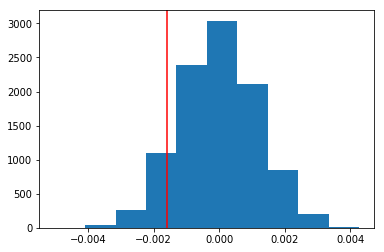

In [73]:
plt.hist(null_vals);
plt.axvline(x=act_diff,color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [72]:
# actual difference
p_actnew = df2.query('landing_page == "new_page"').converted.mean()
p_actold = df2.query('landing_page == "old_page"').converted.mean()
act_diff = p_actnew - p_actold

In [35]:
# p_value linked to the H0 and H1 of part II
(null_vals < act_diff).mean() + (null_vals > 0 + (0 - act_diff)).mean()

0.18590000000000001

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- in point j, the "p-value" was computed. 
- This is the probability of observing your statistics (or one more extreme in favor of the alternative) if the null hypothesis is true.
- this value needs to be compared to a tresh-hold set up to avoid a Type I error (deciding the alternative (H1) is true,when actually (H0) is true. The threshold depends on the application and consequences of such mistakes. The higher the consequences the lower the value of this threshold (called alpha). Here alpha = 0.05.
- when p-value <= alpha : Reject H0 
- when p-value > alpha : Fail to reject H0
- Here as p-value = 0.18 > 0.05 => we FAIL to REJECT H0


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" & converted == 1').converted.count()
convert_new = df2.query('landing_page=="new_page" & converted == 1').converted.count()
n_old = df2.query('landing_page=="old_page"').converted.count()
n_new = df2.query('landing_page=="new_page"').converted.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new])

In [38]:
print(z_score, p_value)

1.31092419842 0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- Here as p-value = 0.19 > 0.05 => we FAIL to REJECT H0
- So we can't reject the hypothesis of the convertion rate for the new page being equal to the  conversion rate of the old page.
- this seems in accordance to the plot of the simulated distribution in point i. (distribution very close to the 0) 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**As we want to predict 2 possible outcomes (0 or 1), we need to use a logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

In [40]:
df2['intercept'] = 1

In [50]:
# verify that the correct columns were created
df2.head(5)

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [42]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

In [43]:
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [51]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 28 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:26:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated  is 0.19 . In the case of logistic regression, the origine of the p-value, comes obviously also from the hypothesis testing. The null hyp, there is no relationship between the 2 variables and the alternative hyp, there is a relationship between the 2 variables. Here as p-value > 0.05, we fail to reject the null**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**In the real world, the evolution of the dependant variable is rarely linked to only one independant variable. It's often interesting, to add some additional independant variables in the regression (for example, here timestamp or if we would dispose, gender, age,... ). On the otherside, we need to be carefull with adding variables, those cann't be correlated between each others. This could lead to unstable model, for example not precise and with high confidence intervals. One method, is to first run the univariate logistic regression with several variables, and keep only those for the multivariate analisis that meet a certain cut-off with regards to the p-value.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [45]:
# reading the countries.csv file
df_co = pd.read_csv('countries.csv')

In [ ]:
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

In [61]:
df_co[['CA','UK','US']] = pd.get_dummies(df_co['country'])

In [65]:
# check if the creation of the dummie variables worked correctly
df_co.head(3)

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0


In [66]:
df_combined = df2.merge(df_co, left_on='user_id',right_on='user_id',how='inner')

In [67]:
# check if the merge worked correctly
df_combined.head(3)

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [69]:
logit_co = sm.Logit(df_combined['converted'],df_combined[['intercept','ab_page','CA','UK']])

In [70]:
results = logit_co.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 28 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        11:10:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**When looking at the p-values for CA and UK, we notice 0.13 and 0.457, as those are higher than the threshold of 0.05, we assume those don't have significant effect on the conversion rate**